In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('MIXED_DATASET_ALL_ANTIBIOTICS.csv', sep = ',')

In [3]:
FINAL = pd.read_csv('FINAL.csv', sep = ',')
FINAL_pose1 = pd.read_csv('FINAL_pose1.csv', sep = ',')

In [4]:
FINAL_pose2 = pd.read_csv('FINAL_pose2.csv', sep = ',')

# Deleting useless interactions

In [5]:
all_residues = FINAL_pose1.columns.tolist()

#to exclude
no_col = ['name', 'Permeability coefficient', 'Charge', 'Canonical SMILES','A:113(ASP)_bond', 'A:117(GLU)_bond', 'A:16(LYS)_bond',
       'A:42(ARG)_bond', 'A:82(ARG)_bond', 'A:132(ARG)_bond']

residues = [residue for residue in all_residues if residue not in no_col]


In [6]:
list_for_dataframe = []
for res in residues:
    sum_column = 0
    list_inf = []
    
    for x in FINAL_pose1.index:
        ugu = FINAL_pose1.loc[x, res].split(' ')
        for y in ugu: 
            if y == '1':
                sum_column = sum_column + 1
            else:
                sum_column = sum_column + 0

    if sum_column == 0:
        FINAL_pose1.drop(columns = [res],axis = 1, inplace=True)
    else:
        list_inf.append(res)  
        list_inf.append(sum_column)      
        list_for_dataframe.append(list_inf) 

interaction_dist = pd.DataFrame(np.array(list_for_dataframe), columns = ["Residue", "number of bonds"])
interaction_dist['number of bonds'] = interaction_dist['number of bonds'].astype(str).astype(int)

#interaction_dist['number of bonds'].astype(str).astype(int) 
interaction_dist

,Residue,number of bonds
0,A:113(ASP),16
1,A:118(PHE),1
2,A:119(GLY),2
3,A:121(ASP),1
4,A:132(ARG),37
5,A:16(LYS),6
6,A:310(TYR),4
7,A:38(MET),1
8,A:40(TYR),4
9,A:42(ARG),18


<AxesSubplot: xlabel='number of bonds', ylabel='Residue'>

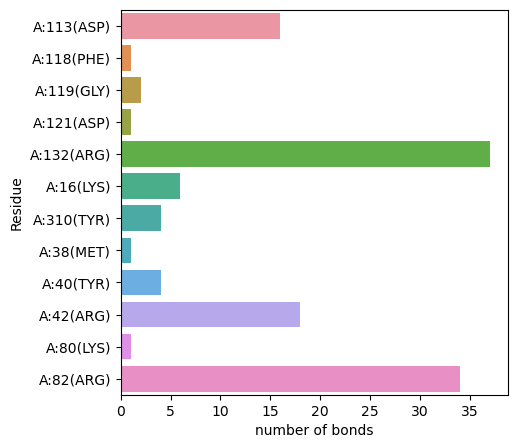

In [7]:
fig, ax = plt.subplots(1,1,figsize = (5, 5))
sns.barplot(
    data=interaction_dist, x="number of bonds", y="Residue",
     ax = ax
)

<AxesSubplot: xlabel='Charge', ylabel='Permeability coefficient'>

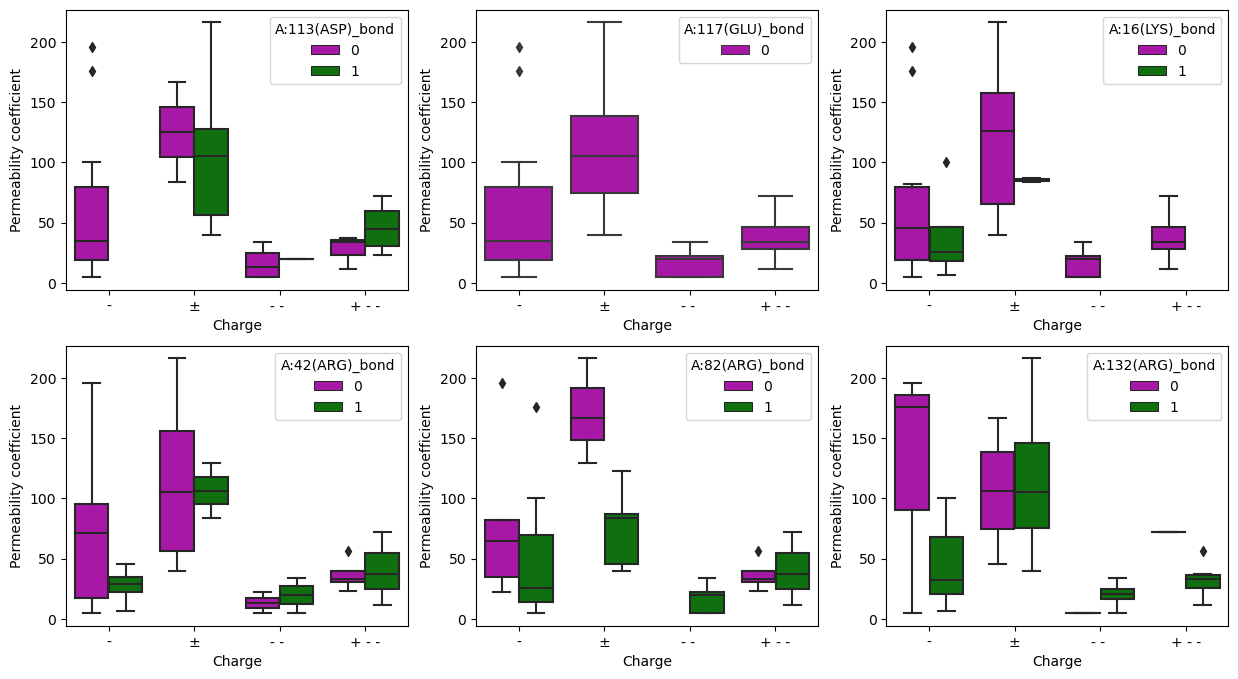

In [8]:
fig, axes = plt.subplots(2,3, figsize = (15, 8))
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:113(ASP)_bond', palette=["m", "g"], ax = axes[0,0])
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:117(GLU)_bond', palette=["m", "g"], ax = axes[0,1])
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:16(LYS)_bond', palette=["m", "g"], ax = axes[0,2])
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:42(ARG)_bond', palette=["m", "g"], ax = axes[1,0])
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:82(ARG)_bond', palette=["m", "g"], ax = axes[1,1])
sns.boxplot(data=FINAL_pose1, x='Charge', y="Permeability coefficient", hue = 'A:132(ARG)_bond', palette=["m", "g"], ax = axes[1,2])

## Tanimoto simularity based on left residues

In [9]:
FINAL_pose1_int_left = interaction_dist['Residue'].tolist() 

FINAL_pose1['interaction_1Dstring'] = 0

for x in FINAL_pose1.index:
    oneD_int = []
    for y in FINAL_pose1_int_left:
        cell_1 = FINAL_pose1.loc[x,y]
        oneD_int.append(cell_1)
        
    FINAL_pose1.loc[x, 'interaction_1Dstring'] = " ".join(oneD_int)
    #table_int.loc[x, 'interaction_1Dstring'] = oneD_int

In [10]:
list_of_features = ['Ligand', 'glide rotatable bonds', 'docking score',
       'glide ligand efficiency', 'glide ligand efficiency sa',
       'glide ligand efficiency ln', 'glide gscore', 'glide lipo',
       'glide hbond', 'glide rewards', 'glide evdw', 'glide ecoul',
       'glide erotb', 'glide esite', 'glide emodel', 'glide energy',
       'glide einternal', 'res:A132 vdw', 'res:A132 coul', 'res:A132 hbond',
       'res:A132 dist', 'res:A132 Eint', 'res:A117 vdw', 'res:A117 coul',
       'res:A117 hbond', 'res:A117 dist', 'res:A117 Eint', 'res:A113 vdw',
       'res:A113 coul', 'res:A113 hbond', 'res:A113 dist', 'res:A113 Eint',
       'res:A82 vdw', 'res:A82 coul', 'res:A82 hbond', 'res:A82 dist',
       'res:A82 Eint', 'res:A42 vdw', 'res:A42 coul', 'res:A42 hbond',
       'res:A42 dist', 'res:A42 Eint', 'res:A16 vdw', 'res:A16 coul',
       'res:A16 hbond', 'res:A16 dist', 'res:A16 Eint']

In [11]:
dict_append = dict()
for name in list_of_features:
    dict_append[name] = []

dict_append['MIN_glide_gscore'] = []
dict_append['MAX_glide_gscore'] = []
dict_append['Tanimoto_coef'] = []

In [12]:
for index_1 in FINAL_pose1.index:
    name_antib = FINAL_pose1.loc[index_1,'name']
    reference = FINAL_pose1.loc[index_1,'interaction_1Dstring'].split(' ')

    tanimoto_coef_final = 0 
    ind_pose = 0
    new_column_list = []
    
    all_poses = FINAL[FINAL['name'] == name_antib]
    MIN = all_poses['glide gscore'].min()
    MAX = all_poses['glide gscore'].max()

    #interaction fingerprints for each pose based on chosen residues
    for x in all_poses.index:
        oneD_int = []
        
        for y in FINAL_pose1_int_left:
            cell_1 = all_poses.loc[x,y]
            #print(cell_1)
            oneD_int.append(cell_1)

        pose_int = " ".join(oneD_int).split(' ')

        #compare each pose with reference
        common = 0
        for i in range(len(pose_int)):
            if reference[i] == pose_int[i]:
                common = common + 1

        tanimoto_coef = common/ len(pose_int)

        if tanimoto_coef > tanimoto_coef_final:
            tanimoto_coef_final = tanimoto_coef
            ind_pose = x 

    glide_gscore = all_poses.loc[ind_pose, 'glide gscore']

    for name in list_of_features:
        dict_append[name].append(all_poses.loc[ind_pose, name])

    dict_append['MIN_glide_gscore'].append(MIN)
    dict_append['MAX_glide_gscore'].append(MAX)
    dict_append['Tanimoto_coef'].append(round(tanimoto_coef_final, 4))



#pd.DataFrame.from_dict(dict_new_cloumn )
FINAL_pose1_tanimoto = pd.concat([FINAL_pose1, pd.DataFrame.from_dict(dict_append)], axis=1)      
        

#### FINAL_pose1_tanimoto - new DataFrame based on the Tanimoto simularity 

# Sampling distribution (normal distribution)

In [13]:
test = FINAL[FINAL['name'] == 'Cephalexin']

/var/folders/m8/v8_kdm011wg6m28tjk9k1lww0000gn/T/ipykernel_37112/2650473370.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(test['glide gscore'],


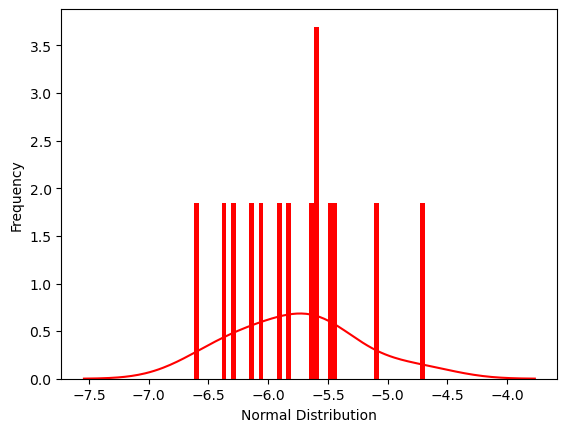

In [14]:
# import packages
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
 
 
# plotting a histogram
ax = sns.distplot(test['glide gscore'],
                  bins=50,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()

In [15]:
from scipy.stats import norm
import numpy as np

glide_gscore_list_prob = []

for index_1 in FINAL_pose1.index:
    name_antib = FINAL_pose1.loc[index_1,'name']
    all_poses = FINAL[FINAL['name'] == name_antib]

    mean = np.mean(all_poses['glide gscore'])
    std = np.std(all_poses['glide gscore'])
    
    feature = 0 
    prob = 0

    for i in all_poses['glide gscore']:
        probability_pdf = norm.pdf(i, loc=mean, scale=std)
        feature = feature + i*probability_pdf
        prob = prob + probability_pdf

    glide_gscore_list_prob.append(feature/prob)

#print(len(glide_gscore_list_prob)) 
#print(glide_gscore_list_prob)   

In [16]:
FINAL_pose1_probability = FINAL_pose1.copy()
FINAL_pose1_probability['glide gscore'] = glide_gscore_list_prob
FINAL_pose1_probability.head()

,name,Permeability coefficient,Charge,A:113(ASP),A:118(PHE),A:119(GLY),A:121(ASP),A:132(ARG),A:16(LYS),A:310(TYR),...,A:82(ARG),Canonical SMILES,A:113(ASP)_bond,A:117(GLU)_bond,A:16(LYS)_bond,A:42(ARG)_bond,A:82(ARG)_bond,A:132(ARG)_bond,interaction_1Dstring,glide gscore
0,Cefacetrile,100,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 1 1 0 0 0 0 0 0 0 0 0 0 0,CC(OCC1=C(C([O-])=O)N2C(SC1)C(NC(CC#N)=O)C2=O)=O,0,0,1,0,1,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-5.343361
1,7-alfa-H-cefmetazole,82,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,CN1C(SCC2=C(C([O-])=O)N3C(SC2)C(NC(CSCC#N)=O)(...,0,0,0,0,0,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-4.250650
2,Cefazolin,77,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 1,...,0 1 1 0 0 0 0 0 0 0 0 0 0 0,CC1=NN=C(SCC2=C(C([O-])=O)N3C(SC2)C(NC(CN4C=NN...,0,0,0,0,1,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-5.171005
3,Cefmetazole,65,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0 0 0 0 0 0 0 0 0 0 0 0 0 0,CN1C(SCC2=C(C([O-])=O)N3C(SC2)C(NC(CSCC#N)=O)(...,0,0,0,0,0,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-4.250650
4,Cefoxitin,46,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 1,...,0 0 0 0 0 0 1 0 0 1 0 0 0 0,COC1(NC(CC2=CC=CS2)=O)C3N(C(C([O-])=O)=C(COC(N...,0,0,0,1,1,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-5.130675


# Sampling distribution (The Boltzmann distribution)

In [98]:
columns_Boltzmann = []
for property in FINAL.columns.tolist():
    if ((property[0] != 'A') and (property != 'name') and (property != 'Ligand') and (property != 'interaction_1Dstring')):
        columns_Boltzmann.append(property)
#columns_Boltzmann

In [99]:
FINAL_pose1_Boltzmann_distribution = FINAL_pose1.copy()

In [100]:
k=8.314
T = 298

for descriptor in columns_Boltzmann:
    descriptor_values = []
    
    for index_1 in FINAL_pose1.index:
        name_antib = FINAL_pose1.loc[index_1,'name']
        all_poses = FINAL[FINAL['name'] == name_antib]
        
        denominator = 0 
        for score in all_poses[descriptor]:
            numerator = np.exp(-(score  / (k*T))) 
            denominator = denominator + numerator

        feature = 0 
        prob = 0 

        for score in all_poses[descriptor]:
            numerator = np.exp(-(score  / (k*T)))
            prob_boltz = numerator / denominator
        
            feature = feature + score*prob_boltz
            prob = prob + prob_boltz

        descriptor_values.append(feature/prob)

    FINAL_pose1_Boltzmann_distribution[descriptor] = descriptor_values


In [101]:
FINAL_pose1_Boltzmann_distribution.head()

,name,Permeability coefficient,Charge,A:113(ASP),A:118(PHE),A:119(GLY),A:121(ASP),A:132(ARG),A:16(LYS),A:310(TYR),...,res:A42 vdw,res:A42 coul,res:A42 hbond,res:A42 dist,res:A42 Eint,res:A16 vdw,res:A16 coul,res:A16 hbond,res:A16 dist,res:A16 Eint
0,Cefacetrile,100,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 1 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,0.208149,-46.522255,-0.266209,1.920481,-46.573079,-0.209556,-40.684949,-0.141603,2.047184,-41.037200
1,7-alfa-H-cefmetazole,82,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,-0.416413,-45.156565,-0.189151,2.013823,-45.753202,-0.895211,-33.847475,-0.057359,2.661736,-34.797940
2,Cefazolin,77,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 1,...,0.493300,-49.021835,-0.345841,1.856658,-48.872230,-1.353749,-45.560702,-0.117753,2.138376,-47.031447
3,Cefmetazole,65,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,...,-0.416413,-45.156565,-0.189151,2.013823,-45.753202,-0.895211,-33.847475,-0.057359,2.661736,-34.797940
4,Cefoxitin,46,-,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 1 1 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 0 0 0 0 0 0 0 0 0 0 0 0 1,...,0.388698,-47.231453,-0.241804,1.915774,-47.080702,-0.898539,-35.986069,-0.051468,2.530876,-36.935541


Text(0.5, 1.0, 'Boltzmann_distribution')

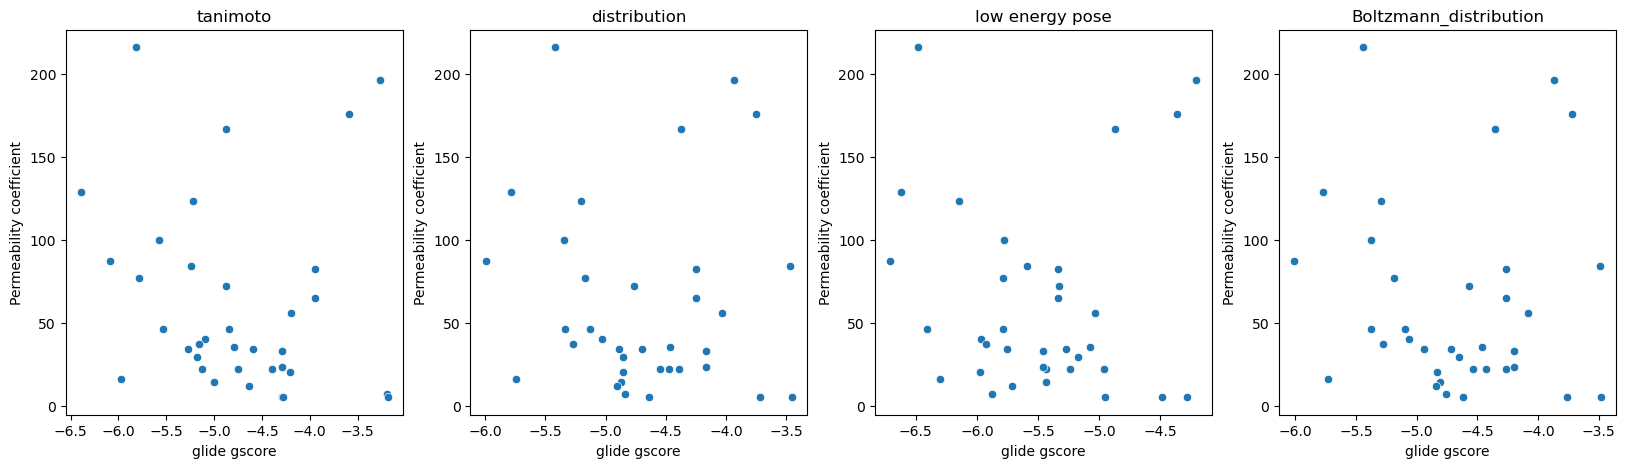

In [102]:
fig, axes = plt.subplots(1,4, figsize = (20, 5))
sns.scatterplot(data=FINAL_pose1_tanimoto, x='glide gscore', y="Permeability coefficient", ax = axes[0])
sns.scatterplot(data=FINAL_pose1_probability, x='glide gscore', y="Permeability coefficient", ax = axes[1])
sns.scatterplot(data=FINAL_pose2, x='glide gscore', y="Permeability coefficient", ax = axes[2])
sns.scatterplot(data=FINAL_pose1_Boltzmann_distribution, x='glide gscore', y="Permeability coefficient", ax = axes[3])

axes[0].set_title('tanimoto')
axes[1].set_title('distribution')
axes[2].set_title('low energy pose')
axes[3].set_title('Boltzmann_distribution')

In [103]:
FINAL_pose1_tanimoto.to_csv(r'/Users/sashaolshanova/Git/New_project/Gram Negative Permeation - OmpF/FINAL_pose1_tanimoto.csv', index=False, header=True)
FINAL_pose1_probability.to_csv(r'/Users/sashaolshanova/Git/New_project/Gram Negative Permeation - OmpF/FINAL_pose1_probability.csv', index=False, header=True)
FINAL_pose1_Boltzmann_distribution.to_csv(r'/Users/sashaolshanova/Git/New_project/Gram Negative Permeation - OmpF/FINAL_pose1_Boltzmann_distribution.csv', index=False, header=True)

#### FINAL - dataframe with all poses
#### FINAL_pose1 - Taking a pose based on interaction fingerprints (based on the majority)
#### FINAL_pose2 - Taking the low energy pose for each lingand
#### FINAL_pose3 dataframe - Voting based on at least ONE interaction existence

## HOW TO CHOOSE OTHER VALUES IN FINAL_pose1?

#### FINAL_pose1_tanimoto - Tanimoto simularity with weited interaction fingerprint string for each ligand
#### FINAL_pose1_probability - Normal distribution among all conformation for each ligand
#### FINAL_pose1_Boltzmann_distribution - Boltzmann_distribution among all conformation for each ligand